<h1><center> SAM pipeline inference on part 5 dataset

In [1]:
# dependencies 
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import numpy as np
import rasterio
import os
import sys
import random
from rasterio.plot import show

In [2]:
#os.chdir("/Users/mayajanvier/Desktop/MVA/Remote sensing/Projet 6/projet_remote")

# SAM

In [3]:
# get sam
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

model_type = "vit_h"
checkpoint_path = 'checkpoint/sam_vit_h_4b8939.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
sam.to(device=device)
predictor = SamPredictor(sam)

In [4]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

In [5]:
def show_prompts(img,prompts,labels):
    plt.figure(figsize=(10,10))
    plt.imshow(img)
    show_points(prompts, labels, plt.gca())
    plt.axis('on')
    plt.show() 

def sam_predict(input_points,input_labels):
    masks, scores, logits = predictor.predict(
    point_coords=input_points,
    point_labels=input_labels,
    multimask_output=True,)
    return masks, scores, logits
    
def show_predictions(masks, scores,input_points, input_labels,img):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10,10))
        plt.imshow(img)
        show_mask(mask, plt.gca())
        show_points(input_points, input_labels, plt.gca())
        plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show() 


# Processing functions for SAR data

In [6]:
# file processing
def read_rasterio(fp):
    img = rasterio.open(fp)
    img = img.read()
    img = np.moveaxis(img, 0, -1)
    return img

def standardize_minmax(array):
    stand = (array - array.min()) / (array.max() - array.min())
    return (stand * 255).astype(np.uint8)

def sar2rgb(path_sar_image):
    sar = read_rasterio(path_sar_image)
    vv = standardize_minmax(sar[:,:,0])
    vh = standardize_minmax(sar[:,:,1])
    diff = vv - vh
    img_3d = np.stack([vv,vh,diff], axis=-1) 
    return img_3d


In [7]:
# Morphological processing
from skimage.filters import try_all_threshold, threshold_li, frangi, median, threshold_multiotsu

def morphological_processing(vh_band):
    mask = vh_band < threshold_li(vh_band)
    return mask

def mean_mask(vh_band):
    mask = vh_band < np.mean(vh_band)
    return mask 

In [8]:
# Get prompts methods 
def get_prompt_points(mask):
    step = len(mask) // 10
    prompt_points = []
    labels = []
    
    for i in range(0, mask.shape[0], step):
        for j in range(0, mask.shape[1], step):
            submask = mask[i:i+step, j:j+step]
            land_count = np.count_nonzero(submask == False)
            water_count = np.count_nonzero(submask == True)
            
            if land_count > water_count:
                dom_label = 0  # Land is the dominant class
            else:
                dom_label = 1  # Water is the dominant class

            dominant_class_pixels_indices = np.where(submask == dom_label)[0]
            random_pixel_index = np.random.choice(dominant_class_pixels_indices)
            random_pixel_coordinates = np.unravel_index(random_pixel_index, submask.shape)
            prompt_points.append([j + random_pixel_coordinates[1], i + random_pixel_coordinates[0]])
            labels.append(dom_label)

    
    return np.array(prompt_points),np.array(labels)

def get_near_center_points(mask):
    step = len(mask) // 10 
    near_center_points = []
    labels = []
    
    for i in range(0, mask.shape[0], step):
        for j in range(0, mask.shape[1], step):
            submask = mask[i:i+step, j:j+step]
            land_count = np.count_nonzero(submask == False)
            water_count = np.count_nonzero(submask == True)
            
            if land_count > water_count:
                dom_label = 0  # Land is the dominant class
            else:
                dom_label = 1  # Water is the dominant class

            dist_to_center = np.sum(np.abs(np.argwhere(submask == dom_label) - np.array([step // 2, step // 2])), axis=1)
            nearest_index = np.argmin(dist_to_center)
            nearest_coords = np.argwhere(submask == dom_label)[nearest_index]
            
            near_center_points.append([j + nearest_coords[1], i + nearest_coords[0]])  
            labels.append(dom_label)
    
    return np.array(near_center_points), np.array(labels)

def prompt_points(image, window_size=100):
    height, width = image.shape
    
    points = []
    labels = []
    
    # Découper l'image en grilles
    for i in range(0, height, window_size):
        for j in range(0, width, window_size):
            window = image[i:i+window_size, j:j+window_size]
            
            unique, counts = np.unique(window, return_counts=True)
            window_class_counts = dict(zip(unique, counts))
            
            major_class = max(window_class_counts, key=window_class_counts.get)
            
            indices = np.argwhere(window == major_class)
            
            # Choisir un point aléatoire parmi ceux de la classe majoritaire
            if indices.size > 0:
                random_index = random.choice(indices)
                point = [j + random_index[1], i + random_index[0]]  # (x, y)
                points.append(point)
                labels.append(major_class)
    
    return np.array(points), np.array(labels) 


# Pipeline on full image
Issues in the code

In [10]:
img_id = '75'

In [55]:
import tqdm 
def predict(crop):
    vv_band = crop[:,:,0]
    vh_band = crop[:,:,1]

    frangi_mask = frangi(vh_band,sigmas=range(1,5,2))
    mask = mean(frangi_mask, disk(5))
    mask = mask > 1.5 * threshold_li(mask)

    #new image
    img_sam = np.stack([vv_band,vh_band, mask],axis=-1)

    # prompts and labels for SAM 
    prompts, labels = prompt_points(mask, window_size=mask.shape[0]//10)

    predictor.set_image(img_sam.astype(np.uint8))

    # predict
    masks, scores, logits = sam_predict(prompts,labels)

    return masks, scores, logits 


def predict_full_image3500(img_id,folder):
    img_path = f'part{folder}/{img_id}/sentinel12_s1_{img_id}_img.tif'
    mask_path = f'part{folder}/{img_id}/sentinel12_s1_{img_id}_msk.tif'

    true_mask = read_rasterio(mask_path)
    img = sar2rgb(img_path)
    predictions = []

    crop_step = 3500
    h, w = img[:,:,0].shape
    for i in tqdm.tqdm(range(0,h,crop_step)):
        for j in tqdm.tqdm(range(0,w,crop_step)):
            crop = img[i:i+crop_step,j:j+crop_step,:]
            masks, scores, logits = predict(crop)

            predictions.append({'masks':masks, 'scores':scores, 'logits': logits})
    return predictions




pred = predict_full_image3500('9','1')

  0%|          | 0/4 [00:00<?, ?it/s]/var/folders/hd/6gcp429169ldrntwtps0b1_m0000gp/T/ipykernel_29840/1842350940.py:37: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  masks, scores, logits = predict(crop)
100%|██████████| 4/4 [47:15<00:00, 708.88s/it]


In [76]:
def reconstruction(predictions,img_id,folder, num_mask=2):
    img_path = f'part{folder}/{img_id}/sentinel12_s1_{img_id}_img.tif'
    mask_path = f'part{folder}/{img_id}/sentinel12_s1_{img_id}_msk.tif'

    true_mask = read_rasterio(mask_path)
    img = sar2rgb(img_path)
    h,w = img[:,:,0].shape
    mask = np.zeros_like(img[:,:,0])
    crop_step = 3500

    for i in range(0,h//crop_step,crop_step):
        for j in range(0,w//crop_step,crop_step):
            if i+j < len(predictions):
                m= predictions[i+j]['masks'][num_mask]
                mask[i:i+crop_step,j:j+crop_step] = m

    return mask,img,true_mask


    
    
reconstructed,original, true = reconstruction(pred, '9','1',2)


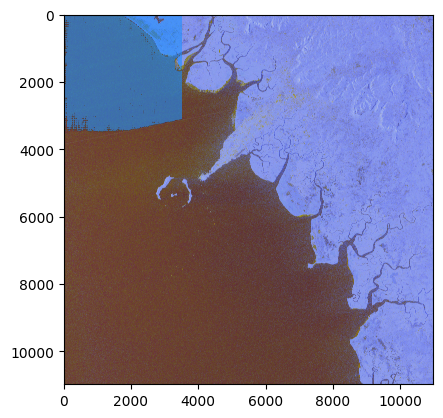

In [77]:
plt.imshow(original)
show_mask(reconstructed, plt.gca())
#plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)

plt.show() 

# Pipeline on crop
Working

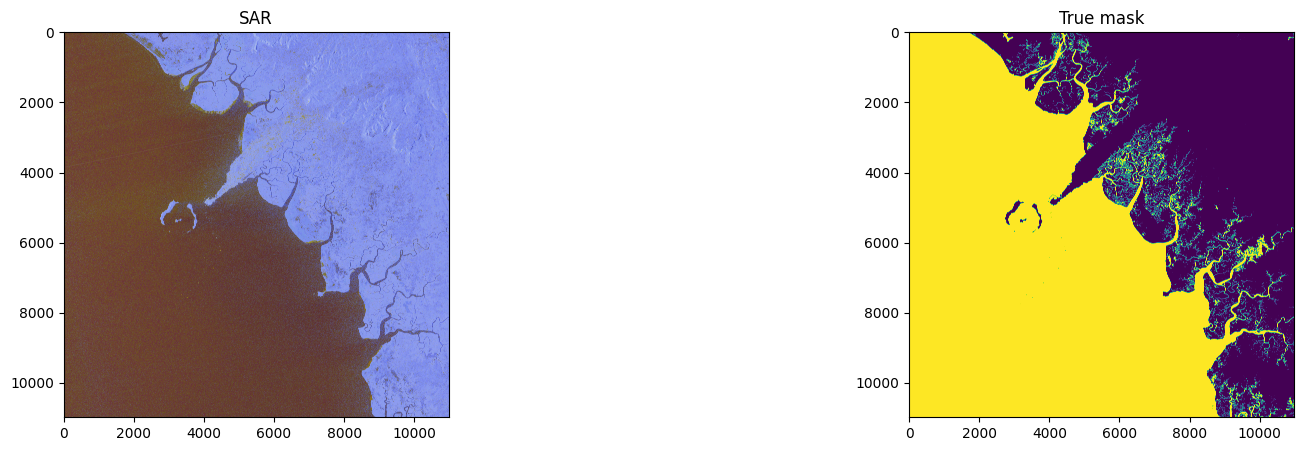

In [87]:
img_path = 'part1/9/sentinel12_s1_9_img.tif' #f'part5/{img_id}/sentinel12_s1_{img_id}_img.tif' #
mask_path = 'part1/9/sentinel12_s1_9_msk.tif' # f'part5/{img_id}/sentinel12_s1_{img_id}_msk.tif'

# plots 
true_mask = read_rasterio(mask_path)
img = sar2rgb(img_path)

# full size
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(img)
ax[0].set_title('SAR')
ax[1].imshow(true_mask)
ax[1].set_title('True mask')
plt.show()


Text(0.5, 1.0, 'Crop')

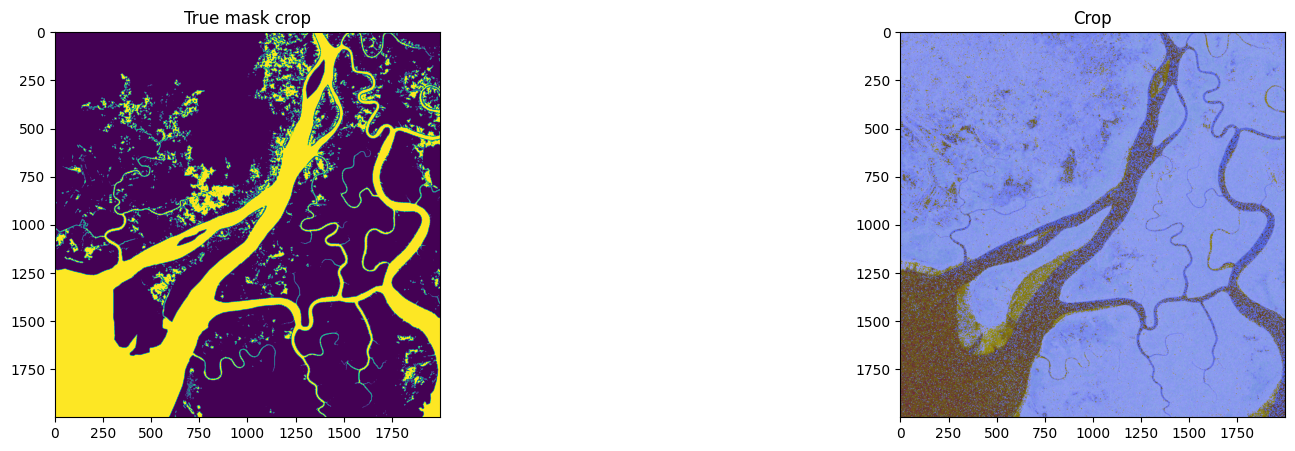

In [88]:
#crop_indices = [7000,11000,1000,5000] #land
#crop_indices = [2000,6000,2000,6000] #water land
crop_indices = [0,2000,3000,5000] #9
crop = img[crop_indices[0]:crop_indices[1],crop_indices[2]:crop_indices[3],:]
crop_resize = cv2.resize(crop,(1000,1000))

# crop 
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].imshow(true_mask[crop_indices[0]:crop_indices[1],crop_indices[2]:crop_indices[3],:])
ax[0].set_title('True mask crop')
ax[1].imshow(crop)
ax[1].set_title('Crop')

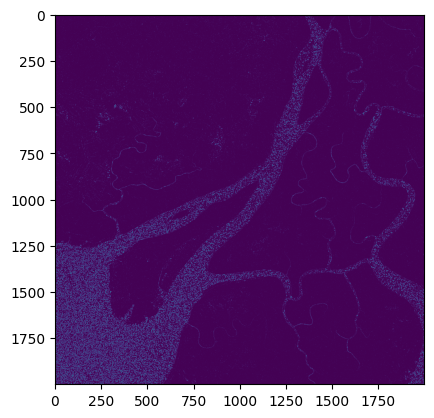

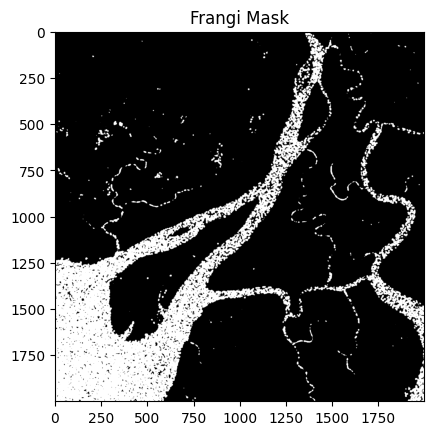

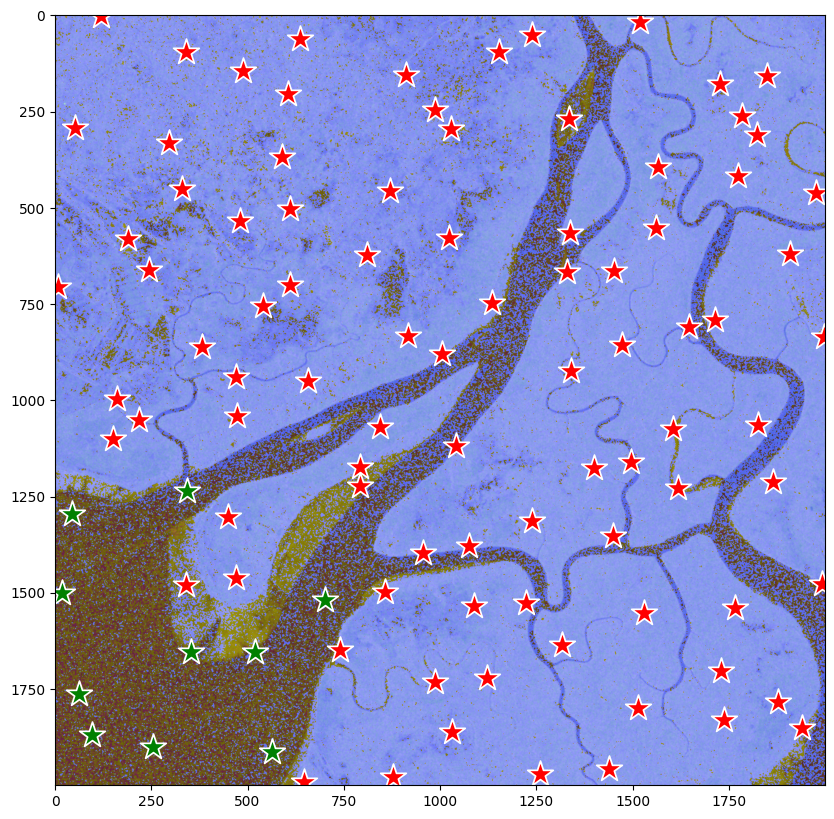

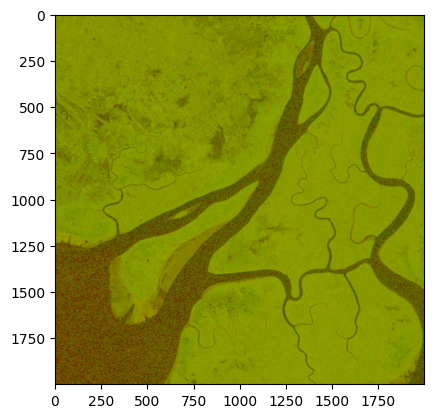

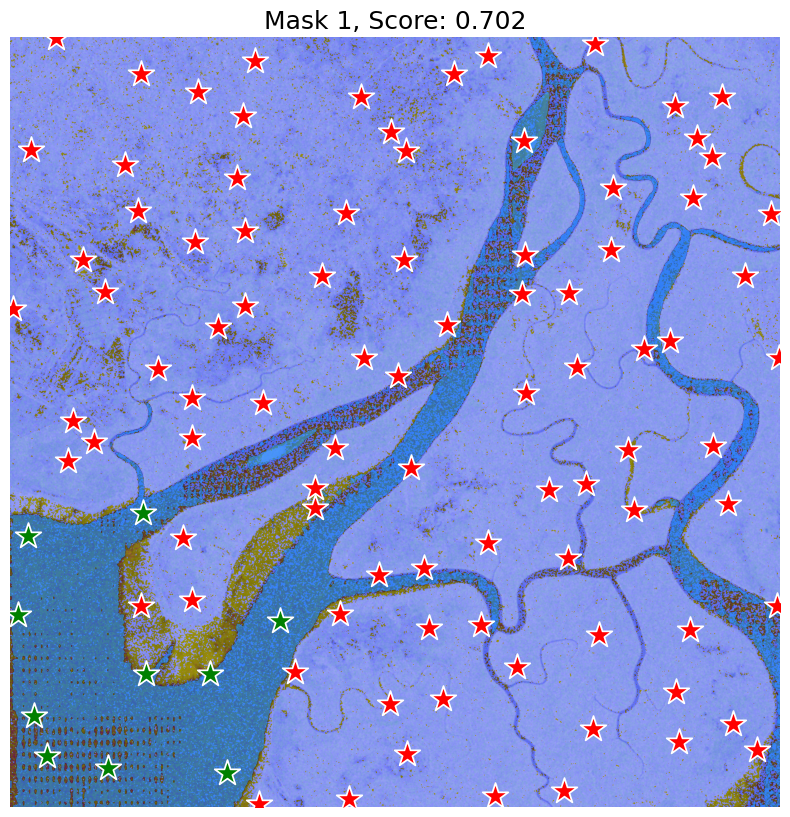

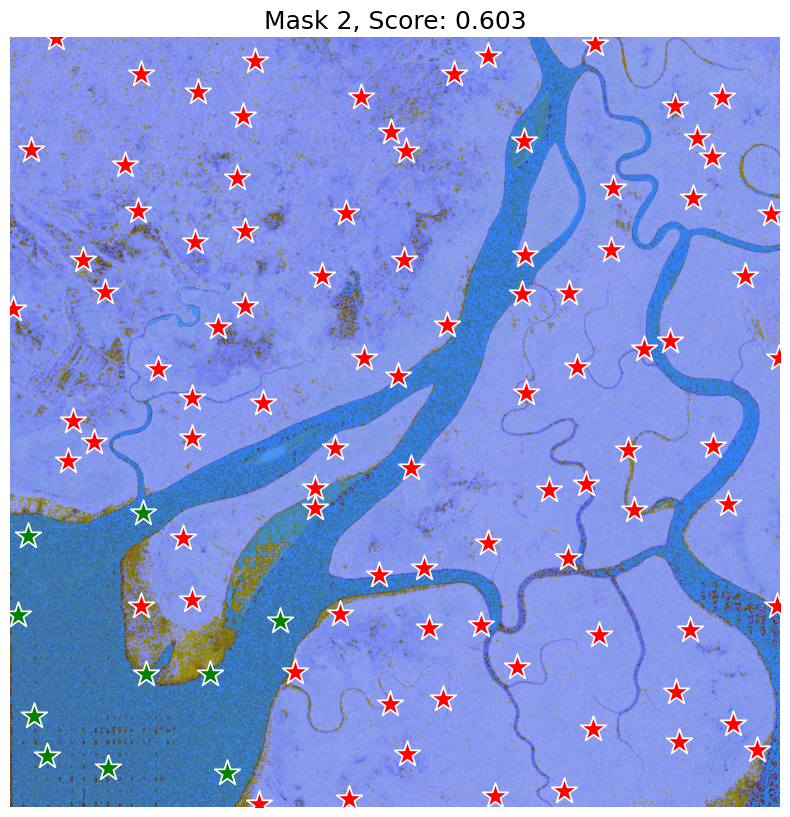

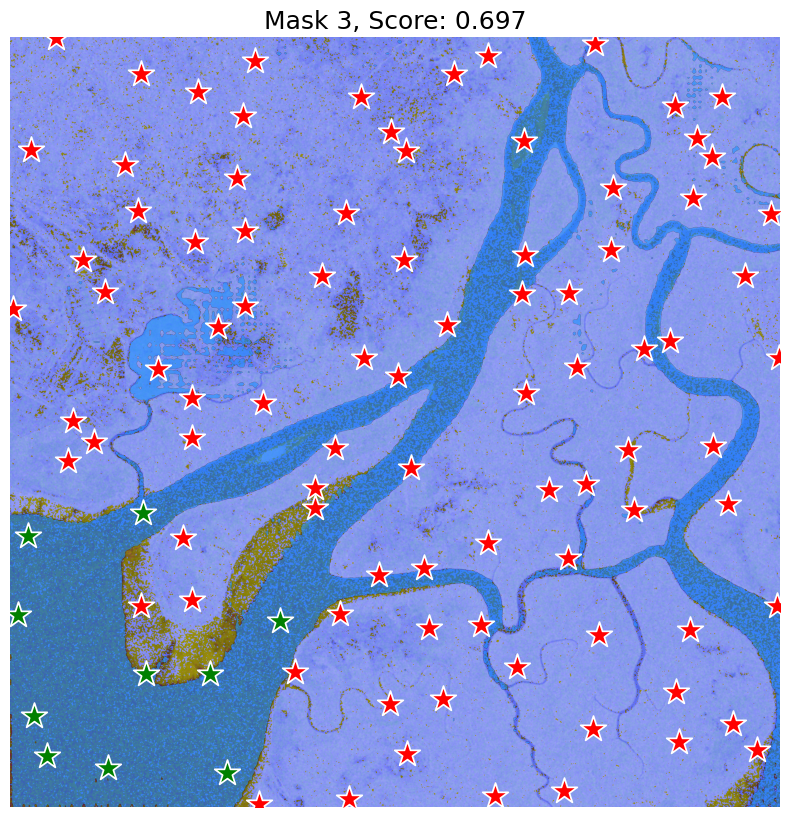

In [89]:
# morphological mask
from skimage.filters import frangi
from skimage.filters.rank import mean
from skimage.morphology import disk

vv_band = crop[:,:,0]
vh_band = crop[:,:,1]

frangi_mask = frangi(vh_band,sigmas=range(1,5,2))
plt.imshow(frangi_mask)
plt.show()
mask = mean(frangi_mask, disk(5))
mask = mask > 1.5 * threshold_li(mask)

plt.imshow(mask,cmap='gray')
plt.title('Frangi Mask')
plt.show()

# prompts and labels for SAM 
prompts, labels = prompt_points(mask, window_size=mask.shape[0]//10)
show_prompts(crop,prompts,labels)

# replace third dim by mask 
plt.imshow(np.stack([vv_band,vh_band,mask],axis=-1))
plt.show()
predictor.set_image(np.stack([vv_band,vh_band, mask],axis=-1).astype(np.uint8))

# predict
masks, scores, logits = sam_predict(prompts,labels)
show_predictions(masks, scores, prompts, labels, crop)

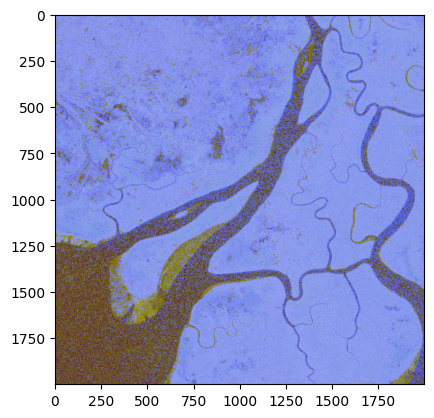

In [83]:
plt.imshow(np.stack([vv_band,vh_band,vv_band-vh_band],axis=-1))
plt.show()